In [ ]:
# --- 기본 설정/라이브러리 ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# --- 경로 수정 ---
CSV_PATH = "dataset/spotify_songs_with_genre_int.csv"
URL = "https://raw.githubusercontent.com/hyeonx3/ML_Project/main/dataset/spotify_songs_with_genre_int.csv"

# --- 데이터 로드 ---
try:
    df = pd.read_csv(CSV_PATH) 
except:
    df = pd.read_csv(URL)
    

# --- 수치형 피처/타깃 지정 ---
features = [
    "danceability","energy","key","loudness","mode","speechiness",
    "acousticness","instrumentalness","liveness","valence","tempo","duration_ms"
]
target_col = "genre_int"

# --- 결측 제거 & 배열 준비 ---
df = df.dropna(subset=features + [target_col]).reset_index(drop=True)
X_raw = df[features].astype(float).values
y = df[target_col].values
class_names = np.unique(y)

# --- 표준화 (PCA/LDA/AE 공통) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

print(f"샘플 수={X_scaled.shape[0]} | 피처 수={X_scaled.shape[1]} | 클래스 수={class_names.size}")

샘플 수=32833 | 피처 수=12 | 클래스 수=6


[PCA] 12 → 11 차원 (설명분산 95%)


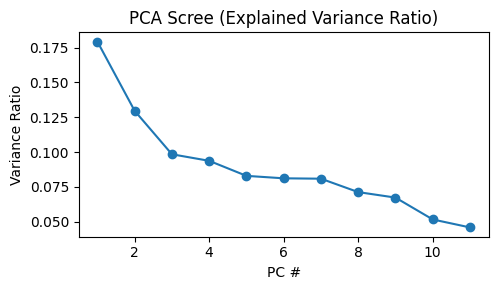

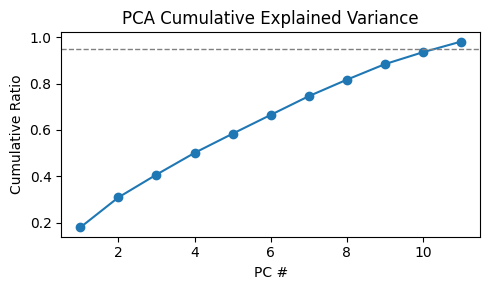

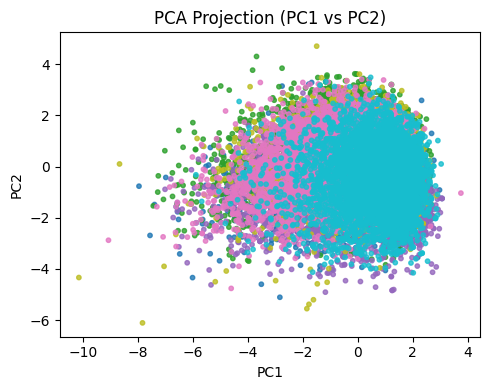

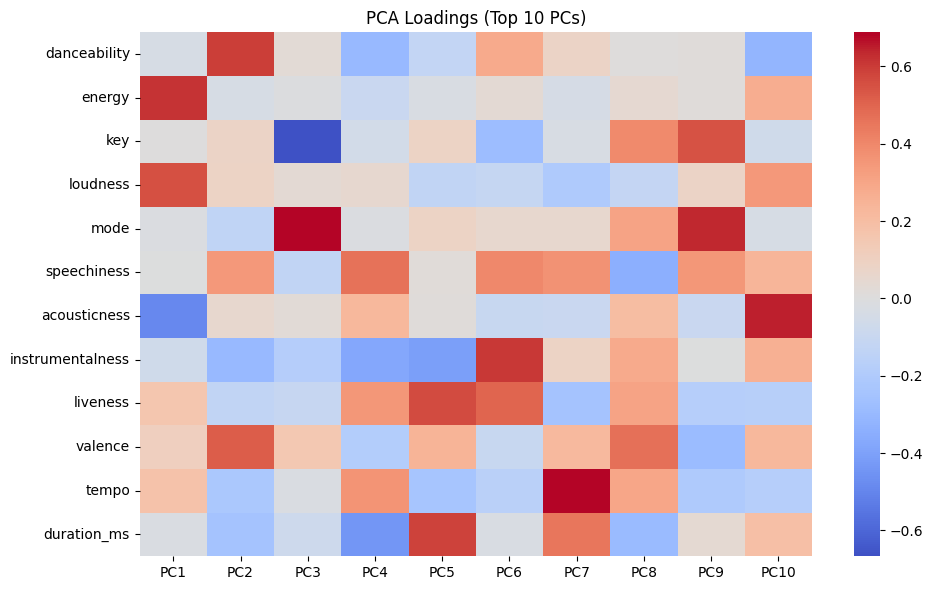

In [2]:
from sklearn.decomposition import PCA
import seaborn as sns

# --- PCA: 설명분산 95% 유지 ---
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
evr = pca.explained_variance_ratio_

print(f"[PCA] {X_scaled.shape[1]} → {X_pca.shape[1]} 차원 (설명분산 95%)")

# 1) Scree
plt.figure(figsize=(5,3))
plt.plot(range(1, len(evr)+1), evr, marker='o')
plt.title("PCA Scree (Explained Variance Ratio)")
plt.xlabel("PC #"); plt.ylabel("Variance Ratio")
plt.tight_layout(); plt.show()

# 2) 누적 설명분산
cum = np.cumsum(evr)
plt.figure(figsize=(5,3))
plt.plot(range(1, len(cum)+1), cum, marker='o')
plt.axhline(0.95, color='gray', ls='--', lw=1)
plt.title("PCA Cumulative Explained Variance")
plt.xlabel("PC #"); plt.ylabel("Cumulative Ratio")
plt.tight_layout(); plt.show()

# 3) PC1 vs PC2 산점 (비지도 → 같은 클래스가 꼭 뭉치지 않아도 정상)
if X_pca.shape[1] >= 2:
    plt.figure(figsize=(5,4))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="tab10", s=10, alpha=0.8)
    plt.title("PCA Projection (PC1 vs PC2)")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.tight_layout(); plt.show()

# 4) 로딩(loading) 히트맵: 어떤 원피처가 각 PC에 기여하는지
loadings = pd.DataFrame(pca.components_.T, index=features,
                        columns=[f"PC{i+1}" for i in range(pca.components_.shape[0])])
plt.figure(figsize=(min(10, 1.2*loadings.shape[1]+4), 6))
sns.heatmap(loadings.iloc[:, :min(10, loadings.shape[1])], cmap="coolwarm", center=0, annot=False)
plt.title("PCA Loadings (Top 10 PCs)")
plt.tight_layout(); plt.show()

[LDA] 축소 후 5 차원 (클래스 수=6, 이론상 최대 5)


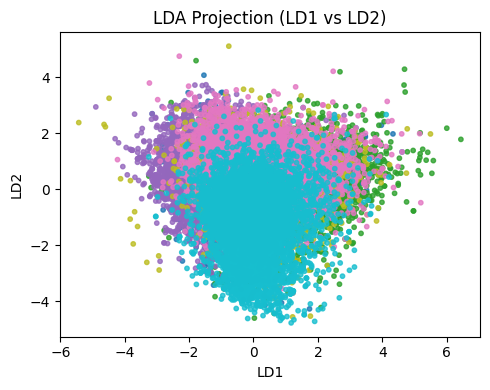

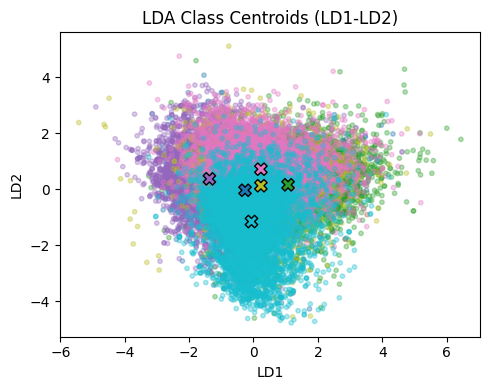

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# --- LDA: 지도 차원 축소 (최대 K-1) ---
n_classes = class_names.size
lda_dim = max(1, min(10, n_classes - 1))  # 보고/보강 관점에서 상한 10
lda = LDA(n_components=lda_dim)
X_lda = lda.fit_transform(X_scaled, y)

print(f"[LDA] 축소 후 {X_lda.shape[1]} 차원 (클래스 수={n_classes}, 이론상 최대 {n_classes-1})")

# 1) LD1 vs LD2
if X_lda.shape[1] >= 2:
    plt.figure(figsize=(5,4))
    plt.scatter(X_lda[:,0], X_lda[:,1], c=y, cmap="tab10", s=10, alpha=0.8)
    plt.title("LDA Projection (LD1 vs LD2)")
    plt.xlabel("LD1"); plt.ylabel("LD2")
    plt.tight_layout(); plt.show()

    # 2) 클래스 센트로이드
    centroids = np.vstack([X_lda[y==k].mean(axis=0) for k in class_names])
    plt.figure(figsize=(5,4))
    plt.scatter(X_lda[:,0], X_lda[:,1], c=y, cmap="tab10", s=10, alpha=0.35)
    plt.scatter(centroids[:,0], centroids[:,1], c=class_names, cmap="tab10",
                s=80, edgecolors='k', marker='X')
    plt.title("LDA Class Centroids (LD1-LD2)")
    plt.xlabel("LD1"); plt.ylabel("LD2")
    plt.tight_layout(); plt.show()
else:
    # LD가 1D인 경우: 클래스별 분포 확인
    import seaborn as sns
    plt.figure(figsize=(6,3))
    sns.kdeplot(x=X_lda[:,0], hue=y, common_norm=False, fill=True, alpha=0.3, linewidth=1)
    plt.title("LDA 1D Density by Class (LD1)")
    plt.xlabel("LD1")
    plt.tight_layout(); plt.show()

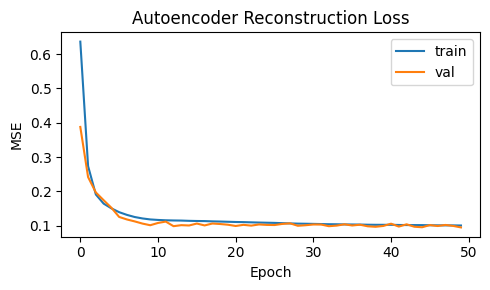

[AE] 12 → 8 차원 축소 완료 | X_ae shape: (32833, 8)


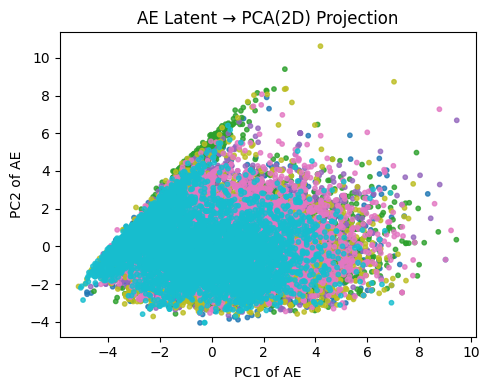

AE bottleneck per-dim variance: [0.926  1.4153 0.4502 0.8879 1.9328 2.0018 0.8662 0.5023]


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

# --- AE 설정 ---
input_dim = X_scaled.shape[1]
encoding_dim = 8  # bottleneck 크기 (6~16 사이 튜닝 추천)

# --- AE 모델 정의 (얕은 대칭 구조) ---
inp = layers.Input(shape=(input_dim,))
x   = layers.Dense(16, activation='relu')(inp)
z   = layers.Dense(encoding_dim, activation='relu')(x)  # bottleneck
x   = layers.Dense(16, activation='relu')(z)
out = layers.Dense(input_dim, activation='linear')(x)

autoencoder = models.Model(inputs=inp, outputs=out)
autoencoder.compile(optimizer='adam', loss='mse')

# --- 학습 ---
history = autoencoder.fit(X_scaled, X_scaled,
                          epochs=50, batch_size=64,
                          shuffle=True, validation_split=0.1, verbose=0)

# --- 학습곡선 ---
plt.figure(figsize=(5,3))
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Autoencoder Reconstruction Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend()
plt.tight_layout(); plt.show()

# --- 잠재벡터 추출 ---
encoder = models.Model(inputs=inp, outputs=z)
X_ae = encoder.predict(X_scaled, verbose=0)

print(f"[AE] {input_dim} → {encoding_dim} 차원 축소 완료 | X_ae shape: {X_ae.shape}")

# --- AE 잠재공간 2D 투영(빠른 확인용: PCA) ---
from sklearn.decomposition import PCA as _PCA
pca_ae = _PCA(n_components=2, random_state=42)
X_ae_2d = pca_ae.fit_transform(X_ae)

plt.figure(figsize=(5,4))
plt.scatter(X_ae_2d[:,0], X_ae_2d[:,1], c=y, cmap="tab10", s=10, alpha=0.8)
plt.title("AE Latent → PCA(2D) Projection")
plt.xlabel("PC1 of AE"); plt.ylabel("PC2 of AE")
plt.tight_layout(); plt.show()

# --- 잠재 차원별 분산 체크(스케일/활성 확인) ---
print("AE bottleneck per-dim variance:", np.round(X_ae.var(axis=0), 4))

In [5]:
# 원본(표준화) + 각 차원축소 결과를 결합해 다양한 입력 세트 구성
X_base               = X_scaled
X_base_pca           = np.concatenate([X_scaled, X_pca], axis=1)
X_base_lda           = np.concatenate([X_scaled, X_lda], axis=1)
X_base_ae            = np.concatenate([X_scaled, X_ae], axis=1)
X_base_pca_lda       = np.concatenate([X_scaled, X_pca, X_lda], axis=1)
X_base_pca_ae        = np.concatenate([X_scaled, X_pca, X_ae], axis=1)
X_base_lda_ae        = np.concatenate([X_scaled, X_lda, X_ae], axis=1)
X_base_pca_lda_ae    = np.concatenate([X_scaled, X_pca, X_lda, X_ae], axis=1)

print("입력 구성/차원:")
print("  Base                    :", X_base.shape)
print("  Base + PCA              :", X_base_pca.shape)
print("  Base + LDA              :", X_base_lda.shape)
print("  Base + AE               :", X_base_ae.shape)
print("  Base + PCA + LDA        :", X_base_pca_lda.shape)
print("  Base + PCA + AE         :", X_base_pca_ae.shape)
print("  Base + LDA + AE         :", X_base_lda_ae.shape)
print("  Base + PCA + LDA + AE   :", X_base_pca_lda_ae.shape)

입력 구성/차원:
  Base                    : (32833, 12)
  Base + PCA              : (32833, 23)
  Base + LDA              : (32833, 17)
  Base + AE               : (32833, 20)
  Base + PCA + LDA        : (32833, 28)
  Base + PCA + AE         : (32833, 31)
  Base + LDA + AE         : (32833, 25)
  Base + PCA + LDA + AE   : (32833, 36)
